In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import time
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler, scale
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

# 데이터 불러오기 / 데이터 정리

In [3]:
Medicine_nonfinance = pd.read_excel('./data/dongboo/비재무/제약_비재무_TOTAL_최종.xlsx')

In [4]:
# krx에서 가져온 자료
Medicine_stock = pd.read_excel('./data/dongboo/제약_주가_total_krx.xlsx')

# IT_stock = pd.read_excel('./data/dongboo/IT_TOTAL_주가.xlsx')
# Medicine_stock = pd.read_excel('./data/dongboo/제약_TOTAL_주가.xlsx')

In [5]:
Medicine = pd.merge(Medicine_nonfinance,Medicine_stock,how = 'left', on = ['회사명','거래소코드','회계년도'])

In [6]:
Medicine

,회사명,거래소코드,회계년도,주식의 종류,발행할 주식의 총수(주),현재까지 발행한 주식의 총수(주),현재까지 감소한 주식의 총수(주),유통주식수 (발행주식의 총수 - 자기주식수)(주),이익소각(주),발행주식의 총수 (현재 발행한 주식수 - 현재 감소한 주식수)(주),자기주식수(주),정규+무기계약_기말인원(남)(명),정규+무기계약_기말인원(여)(명),정규+무기계약_기말인원(명),기간제_기말인원(남)(명),기간제_기말인원(여)(명),기간제_기말인원(명),합계_기말인원_남(명),합계_기말인원_여(명),합계_기말인원(명),합계_년간평균급여(천원),합계_1인평균년간급여(천원),합계_평균근속연수,최고가,최저가,종가,거래량,거래대금
0,(주)녹십자,6280,2011/03,10,30000000,13355267,3547510,9787757,0,9807757,20000,0,0,0,0,0,0,1102,226,1328,16339192,12304,7.200000,135500,124500,130000,752060,96933028000
1,(주)녹십자,6280,2012/03,10,30000000,13678499,3547510,10110989,0,10130989,20000,1110,228,1338,0,0,0,1110,228,1338,16991000,13000,7.500000,127000,115000,121000,1098521,133780028250
2,(주)녹십자,6280,2013/03,10,30000000,13678499,3547510,10110989,0,10130989,20000,1190,268,1458,0,0,0,1190,268,1458,19025000,13000,7.000000,159500,149000,154250,596177,91917294500
3,(주)녹십자,6280,2014/03,10,30000000,15234048,3547510,11563178,0,11686538,123360,1253,296,1549,24,0,24,1277,296,1573,18502000,12000,7.083333,134000,123500,128750,307631,39334155000
4,(주)녹십자,6280,2015/03,10,30000000,15234048,3547510,11563178,0,11686538,123360,1336,323,1659,26,0,26,1362,323,1685,21150000,13000,7.083333,180000,139500,159750,1021873,167744781000
5,(주)녹십자,6280,2016/03,10,30000000,15234048,3547510,11563178,0,11686538,123360,1409,363,1772,22,6,28,1431,369,1800,23061000,13000,7.166667,193000,179000,186000,1150900,212294012000
6,(주)녹십자,6280,2017/03,10,30000000,15234048,3547510,11413178,0,11686538,273360,1553,403,1956,14,3,17,1567,406,1973,25807000,13000,7.166667,158500,148000,153250,624748,95786689000
7,(주)녹십자,6280,2018/03,10,30000000,15234048,3547510,11413178,0,11686538,273360,1548,430,1978,12,5,17,1560,435,1995,27076000,13000,7.666667,220000,198000,209000,831730,173035241500
8,(주)녹십자,6280,2011/06,10,30000000,13479587,3547510,9912077,0,9932077,20000,1116,230,1346,0,0,0,1116,230,1346,34805000,26000,7.250000,165500,141500,153500,1061949,164967704250
9,(주)녹십자,6280,2012/06,10,30000000,13678499,3547510,10110989,0,10130989,20000,1139,236,1375,0,0,0,1139,236,1375,33367000,24000,7.583333,150500,129000,139750,776062,109694927500


In [7]:
#del IT['주식매입선택권.1']

# 회사별로 분리

In [8]:
greencross = Medicine[Medicine['회사명'] == '(주)녹십자']
daewoong = Medicine[Medicine['회사명'] == '(주)대웅제약']
yoohan = Medicine[Medicine['회사명'] == '(주)유한양행']
hanmi = Medicine[Medicine['회사명'] == '한미약품(주)']

In [9]:
def classify(stock):
    
    # 회계년도 순으로 정렬 및 인덱스 초기화
    stock.sort_values('회계년도', ascending= True, inplace = True)
    
    stock.reset_index(drop = True, inplace = True)
    
    
    # 새로운 변수 추가
    
    stock['3개월후종가'] = stock['종가'][1:].reset_index(drop=True)
    
    stock['분기수익률'] = (stock['3개월후종가'] - stock['종가']) / stock['종가']
    
    stock['수익률상승하락'] = stock['분기수익률']
    
    for i in range(len(stock)):
        if stock['분기수익률'][i] < 0.005:
            stock['수익률상승하락'][i] = 0
        else:
            stock['수익률상승하락'][i] = 1
        
       
    return stock

In [10]:
classify(greencross)
classify(daewoong)
classify(yoohan)
classify(hanmi)

,회사명,거래소코드,회계년도,주식의 종류,발행할 주식의 총수(주),현재까지 발행한 주식의 총수(주),현재까지 감소한 주식의 총수(주),유통주식수 (발행주식의 총수 - 자기주식수)(주),이익소각(주),발행주식의 총수 (현재 발행한 주식수 - 현재 감소한 주식수)(주),자기주식수(주),정규+무기계약_기말인원(남)(명),정규+무기계약_기말인원(여)(명),정규+무기계약_기말인원(명),기간제_기말인원(남)(명),기간제_기말인원(여)(명),기간제_기말인원(명),합계_기말인원_남(명),합계_기말인원_여(명),합계_기말인원(명),합계_년간평균급여(천원),합계_1인평균년간급여(천원),합계_평균근속연수,최고가,최저가,종가,거래량,거래대금,3개월후종가,분기수익률,수익률상승하락
0,한미약품(주),128940,2011/03,10,16000000,7512061,0,7504311,0,7512061,7750,1435,467,1902,0,0,0,1435,467,1902,23989086,12613,4.800000,87500,74600,81050,718507,57610507200,73850.0,-0.088834,0.0
1,한미약품(주),128940,2011/06,10,16000000,7512061,0,7504311,0,7512061,7750,1483,459,1942,0,0,0,1483,459,1942,44166000,23000,4.960000,77100,70600,73850,879634,65081187100,75550.0,0.023020,1.0
2,한미약품(주),128940,2011/09,10,16000000,7512061,0,7504311,0,7512061,7750,1499,434,1933,0,0,0,1499,434,1933,62231000,32000,5.070000,83100,68000,75550,304899,22588237200,65400.0,-0.134348,0.0
3,한미약품(주),128940,2011/12,10,16000000,7512061,0,7504311,0,7512061,7750,1490,429,1919,0,0,0,1490,429,1919,83117000,43000,5.250000,68300,62500,65400,462293,30233148400,57100.0,-0.126911,0.0
4,한미약품(주),128940,2012/03,10,25000000,7887276,0,7876819,0,7887276,10457,1573,429,2002,0,0,0,1573,429,2002,24805000,12000,5.166667,60300,53900,57100,491161,27979739700,59600.0,0.043783,1.0
5,한미약품(주),128940,2012/06,10,25000000,7887276,0,7876819,0,7887276,10457,1346,419,1765,0,0,0,1346,419,1765,42675000,24000,5.560000,67100,52100,59600,968824,57979706500,89200.0,0.496644,1.0
6,한미약품(주),128940,2012/09,10,25000000,7887276,0,7876819,0,7887276,10457,1334,417,1751,0,0,0,1334,417,1751,60751000,35000,5.650000,94800,83600,89200,677817,60272659000,117500.0,0.317265,1.0
7,한미약품(주),128940,2012/12,10,25000000,7887276,0,7876819,0,7887276,10457,1322,411,1733,0,0,0,1322,411,1733,80709000,47000,5.750000,125000,110000,117500,986390,118356257000,159250.0,0.355319,1.0
8,한미약품(주),128940,2013/03,10,25000000,8281116,0,8268121,0,8281116,12995,1324,431,1755,0,0,0,1324,431,1755,22709000,13000,5.750000,166500,152000,159250,846238,134802296500,160500.0,0.007849,1.0
9,한미약품(주),128940,2013/06,10,25000000,8281116,0,8268121,0,8281116,12995,1315,434,1749,0,0,0,1315,434,1749,43881000,25000,6.000000,173500,147500,160500,1101369,175643059450,139250.0,-0.132399,0.0


In [11]:
greencross = greencross.iloc[:-1,:]
daewoong = daewoong.iloc[:-1,:]
yoohan = yoohan.iloc[:-1,:]
hanmi = hanmi.iloc[:-1,:]

In [12]:
greencross_corr = greencross.corr(method = 'pearson')
df_greencross = pd.DataFrame(greencross_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_greencross.columns = ['지표','3개월후종가']

daewoong_corr = daewoong.corr(method = 'pearson')
df_daewoong = pd.DataFrame(daewoong_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_daewoong.columns = ['지표','3개월후종가']

yoohan_corr = yoohan.corr(method = 'pearson')
df_yoohan = pd.DataFrame(yoohan_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_yoohan.columns = ['지표','3개월후종가']

hanmi_corr = hanmi.corr(method = 'pearson')
df_hanmi = pd.DataFrame(hanmi_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hanmi.columns = ['지표','3개월후종가']

In [13]:
pd.concat([df_greencross.reset_index(drop = True), df_daewoong.reset_index(drop = True),
           df_yoohan.reset_index(drop = True), df_hanmi.reset_index(drop = True)],axis = 1)

,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가
0,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000
1,최고가,0.719608,최저가,0.915958,종가,0.858799,최고가,0.905746
2,종가,0.719570,종가,0.913289,최고가,0.858690,종가,0.892107
3,최저가,0.703807,최고가,0.903792,최저가,0.854375,최저가,0.872062
4,합계_기말인원_여(명),0.645558,정규+무기계약_기말인원(명),0.873611,합계_평균근속연수,0.787942,거래대금,0.790489
5,합계_기말인원(명),0.635535,정규+무기계약_기말인원(여)(명),0.847674,자기주식수(주),0.736998,유통주식수 (발행주식의 총수 - 자기주식수)(주),0.782966
6,합계_기말인원_남(명),0.629191,합계_기말인원_여(명),0.710143,거래대금,0.708051,발행주식의 총수 (현재 발행한 주식수 - 현재 감소한 주식수)(주),0.782657
7,자기주식수(주),0.572928,합계_기말인원(명),0.644079,정규+무기계약_기말인원(여)(명),0.596281,현재까지 발행한 주식의 총수(주),0.782657
8,정규+무기계약_기말인원(여)(명),0.537314,정규+무기계약_기말인원(남)(명),0.574512,합계_기말인원_여(명),0.543245,정규+무기계약_기말인원(여)(명),0.714580
9,기간제_기말인원(명),0.490319,유통주식수 (발행주식의 총수 - 자기주식수)(주),0.560006,정규+무기계약_기말인원(명),0.515214,정규+무기계약_기말인원(명),0.713801


In [14]:
list_corr = []
order = 15 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_greencross.index[:order])):
    list_corr.append(df_greencross.index[:order][i])
    list_corr.append(df_daewoong.index[:order][i])
    list_corr.append(df_yoohan.index[:order][i])
    list_corr.append(df_hanmi.index[:order][i])

variable = pd.Series(list_corr).value_counts()
variable = pd.DataFrame(variable).reset_index()
variable.columns = ['var_index', 'number']

In [15]:
var = []
for i in range(len(variable)):
    var.append(df_greencross[df_greencross.index == variable['var_index'][i]]['지표'].values[0])
var = pd.DataFrame(var)
var.columns = ['var']

In [16]:
corr = pd.concat([variable,var], axis = 1)
corr = corr[['var_index','var','number']]
corr = corr[corr['var'] != '3개월후종가'].reset_index(drop = True)
corr = corr[corr['var'] != '수익률상승하락'].reset_index(drop = True)
corr

,var_index,var,number
0,11,정규+무기계약_기말인원(명),4
1,25,거래대금,4
2,23,종가,4
3,22,최저가,4
4,21,최고가,4
5,17,합계_기말인원(명),4
6,16,합계_기말인원_여(명),4
7,10,정규+무기계약_기말인원(여)(명),4
8,15,합계_기말인원_남(명),3
9,8,자기주식수(주),3


In [17]:
deep_greencross = greencross[corr['var'][0:18]]
deep_yoohan = yoohan[corr['var'][0:18]]
deep_daewoong = daewoong[corr['var'][0:18]]
deep_hanmi = hanmi[corr['var'][0:18]]

deep_greencross['수익률상승하락'] = greencross['수익률상승하락']
deep_yoohan['수익률상승하락'] = yoohan['수익률상승하락']
deep_daewoong['수익률상승하락'] = daewoong['수익률상승하락']
deep_hanmi['수익률상승하락'] = hanmi['수익률상승하락']

In [29]:
deep_hanmi

,정규+무기계약_기말인원(명),거래대금,종가,최저가,최고가,합계_기말인원(명),합계_기말인원_여(명),정규+무기계약_기말인원(여)(명),합계_기말인원_남(명),자기주식수(주),정규+무기계약_기말인원(남)(명),유통주식수 (발행주식의 총수 - 자기주식수)(주),발행주식의 총수 (현재 발행한 주식수 - 현재 감소한 주식수)(주),현재까지 발행한 주식의 총수(주),기간제_기말인원(남)(명),합계_평균근속연수,거래량,기간제_기말인원(여)(명),수익률상승하락
0,1902,57610507200,81050,74600,87500,1902,467,467,1435,7750,1435,7504311,7512061,7512061,0,4.800000,718507,0,0.0
1,1942,65081187100,73850,70600,77100,1942,459,459,1483,7750,1483,7504311,7512061,7512061,0,4.960000,879634,0,1.0
2,1933,22588237200,75550,68000,83100,1933,434,434,1499,7750,1499,7504311,7512061,7512061,0,5.070000,304899,0,0.0
3,1919,30233148400,65400,62500,68300,1919,429,429,1490,7750,1490,7504311,7512061,7512061,0,5.250000,462293,0,0.0
4,2002,27979739700,57100,53900,60300,2002,429,429,1573,10457,1573,7876819,7887276,7887276,0,5.166667,491161,0,1.0
5,1765,57979706500,59600,52100,67100,1765,419,419,1346,10457,1346,7876819,7887276,7887276,0,5.560000,968824,0,1.0
6,1751,60272659000,89200,83600,94800,1751,417,417,1334,10457,1334,7876819,7887276,7887276,0,5.650000,677817,0,1.0
7,1733,118356257000,117500,110000,125000,1733,411,411,1322,10457,1322,7876819,7887276,7887276,0,5.750000,986390,0,1.0
8,1755,134802296500,159250,152000,166500,1755,431,431,1324,12995,1324,8268121,8281116,8281116,0,5.750000,846238,0,1.0
9,1749,175643059450,160500,147500,173500,1749,434,434,1315,12995,1315,8268121,8281116,8281116,0,6.000000,1101369,0,0.0


In [18]:
# import re

In [19]:
# 표준화

from sklearn.preprocessing import StandardScaler

scaler_greencross = StandardScaler()
scale_greencross = pd.DataFrame(scaler_greencross.fit_transform(deep_greencross.iloc[:,:-1]))

scaler_yoohan = StandardScaler()
scale_yoohan = pd.DataFrame(scaler_yoohan.fit_transform(deep_yoohan.iloc[:,:-1]))

scaler_daewoong = StandardScaler()
scale_daewoong = pd.DataFrame(scaler_daewoong.fit_transform(deep_daewoong.iloc[:,:-1]))

scaler_hanmi = StandardScaler()
scale_hanmi = pd.DataFrame(scaler_hanmi.fit_transform(deep_hanmi.iloc[:,:-1]))

# 원래 값으로 변환
# scaler_lg.inverse_transform(scale_lg)

In [20]:
# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_Medicine = pd.concat([deep_greencross,deep_yoohan,deep_daewoong,deep_hanmi], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_Medicine = pd.concat([scale_greencross,scale_yoohan,scale_daewoong,scale_hanmi], ignore_index=True)

scale_Medicine

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-4.289386,-0.335714,-1.004994,-0.960069,-1.024037,-1.392866,-1.359738,-3.489997,-1.402437,-1.109607,-4.496976,-1.876660,-1.853203,-1.853203,-0.887850,-0.083018,-0.029921,-0.649189
1,-0.701793,0.307218,-0.273806,-0.382328,-0.178890,-1.318930,-1.304873,-0.952219,-1.320617,-1.109607,-0.615595,-1.695180,-1.687407,-1.687407,-0.887850,0.108562,0.669269,-0.649189
2,-0.779089,-0.243253,0.006223,0.025489,-0.009860,-1.438049,-1.346022,-0.985320,-1.472569,-1.109607,-0.706022,-1.628638,-1.626615,-1.626615,-0.887850,0.747165,-0.258555,-0.649189
3,-0.731112,-0.325868,-0.227135,-0.501275,0.004226,-1.364113,-1.304873,-0.952219,-1.384904,-1.109607,-0.653853,-1.404814,-1.422133,-1.422133,-0.887850,1.385768,-0.284703,-0.649189
4,-0.723116,0.012493,-1.285023,-1.282924,-1.263496,-1.351790,-1.332305,-0.974286,-1.355683,-1.109607,-0.636463,-1.404814,-1.422133,-1.422133,-0.887850,1.066467,0.751785,-0.649189
5,-0.624497,-0.215113,-0.701629,-0.807137,-0.601464,-1.199812,-1.222575,-0.886016,-1.186198,-1.109607,-0.535603,-1.404814,-1.422133,-1.422133,-0.887850,1.385768,0.024234,-0.649189
6,-0.587182,-0.260631,-0.126013,-0.195412,-0.066203,-1.142306,-1.057980,-0.753610,-1.174510,-1.109607,-0.528647,-1.404814,-1.422133,-1.422133,-0.887850,1.385768,-0.206719,-0.649189
7,-0.405936,-0.331638,-0.732743,-0.722176,-0.728236,-0.862994,-0.865953,-0.599136,-0.858917,-1.109607,-0.340838,-1.404814,-1.422133,-1.422133,-0.887850,1.385768,-0.132888,-0.649189
8,-0.403271,-0.383113,-0.250471,-0.127443,-0.347919,-0.858886,-0.783655,-0.532934,-0.888139,-1.109607,-0.358228,-1.404814,-1.422133,-1.422133,-0.887850,-0.849342,-0.381634,-0.649189
9,-0.301987,-0.727482,-1.113894,-1.231947,-0.995866,-0.702800,-0.646493,-0.422595,-0.724498,-1.073764,-0.260845,0.861032,0.652382,0.652382,-0.887850,-0.849342,-0.723250,-0.649189


In [21]:
scale_Medicine.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.000000,0.421407,0.671329,0.677533,0.660835,0.905004,0.867980,0.942105,0.813030,0.577384,0.911770,0.604050,0.690703,0.690703,0.388951,0.104149,0.232852,0.422014
1,0.421407,1.000000,0.693482,0.640072,0.732704,0.390631,0.393914,0.421347,0.294899,0.278874,0.332257,0.245350,0.340865,0.340865,0.191025,0.214194,0.898285,0.034874
2,0.671329,0.693482,1.000000,0.994329,0.995992,0.646187,0.669392,0.698709,0.523412,0.493407,0.553602,0.351316,0.471110,0.471110,0.261157,0.296970,0.399754,0.205812
3,0.677533,0.640072,0.994329,1.000000,0.980856,0.659878,0.684588,0.708963,0.537718,0.505054,0.559224,0.353236,0.473081,0.473081,0.262050,0.299222,0.336823,0.229228
4,0.660835,0.732704,0.995992,0.980856,1.000000,0.629328,0.650857,0.684264,0.507098,0.479724,0.544596,0.346819,0.465964,0.465964,0.257892,0.293433,0.449210,0.183457
5,0.905004,0.390631,0.646187,0.659878,0.629328,1.000000,0.957307,0.918766,0.914777,0.602339,0.758778,0.588724,0.678821,0.678821,0.489625,0.024698,0.220419,0.608404
6,0.867980,0.393914,0.669392,0.684588,0.650857,0.957307,1.000000,0.962232,0.781814,0.682029,0.648075,0.634430,0.744096,0.744096,0.516222,0.173612,0.239570,0.646015
7,0.942105,0.421347,0.698709,0.708963,0.684264,0.918766,0.962232,1.000000,0.745767,0.676322,0.748498,0.625742,0.741923,0.741923,0.470880,0.207856,0.249085,0.516027
8,0.813030,0.294899,0.523412,0.537718,0.507098,0.914777,0.781814,0.745767,1.000000,0.478967,0.812923,0.422106,0.499497,0.499497,0.382719,-0.133333,0.125504,0.484272
9,0.577384,0.278874,0.493407,0.505054,0.479724,0.602339,0.682029,0.676322,0.478967,1.000000,0.469183,0.430294,0.627393,0.627393,0.356110,0.351853,0.162855,0.334552


In [22]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import matplotlib
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

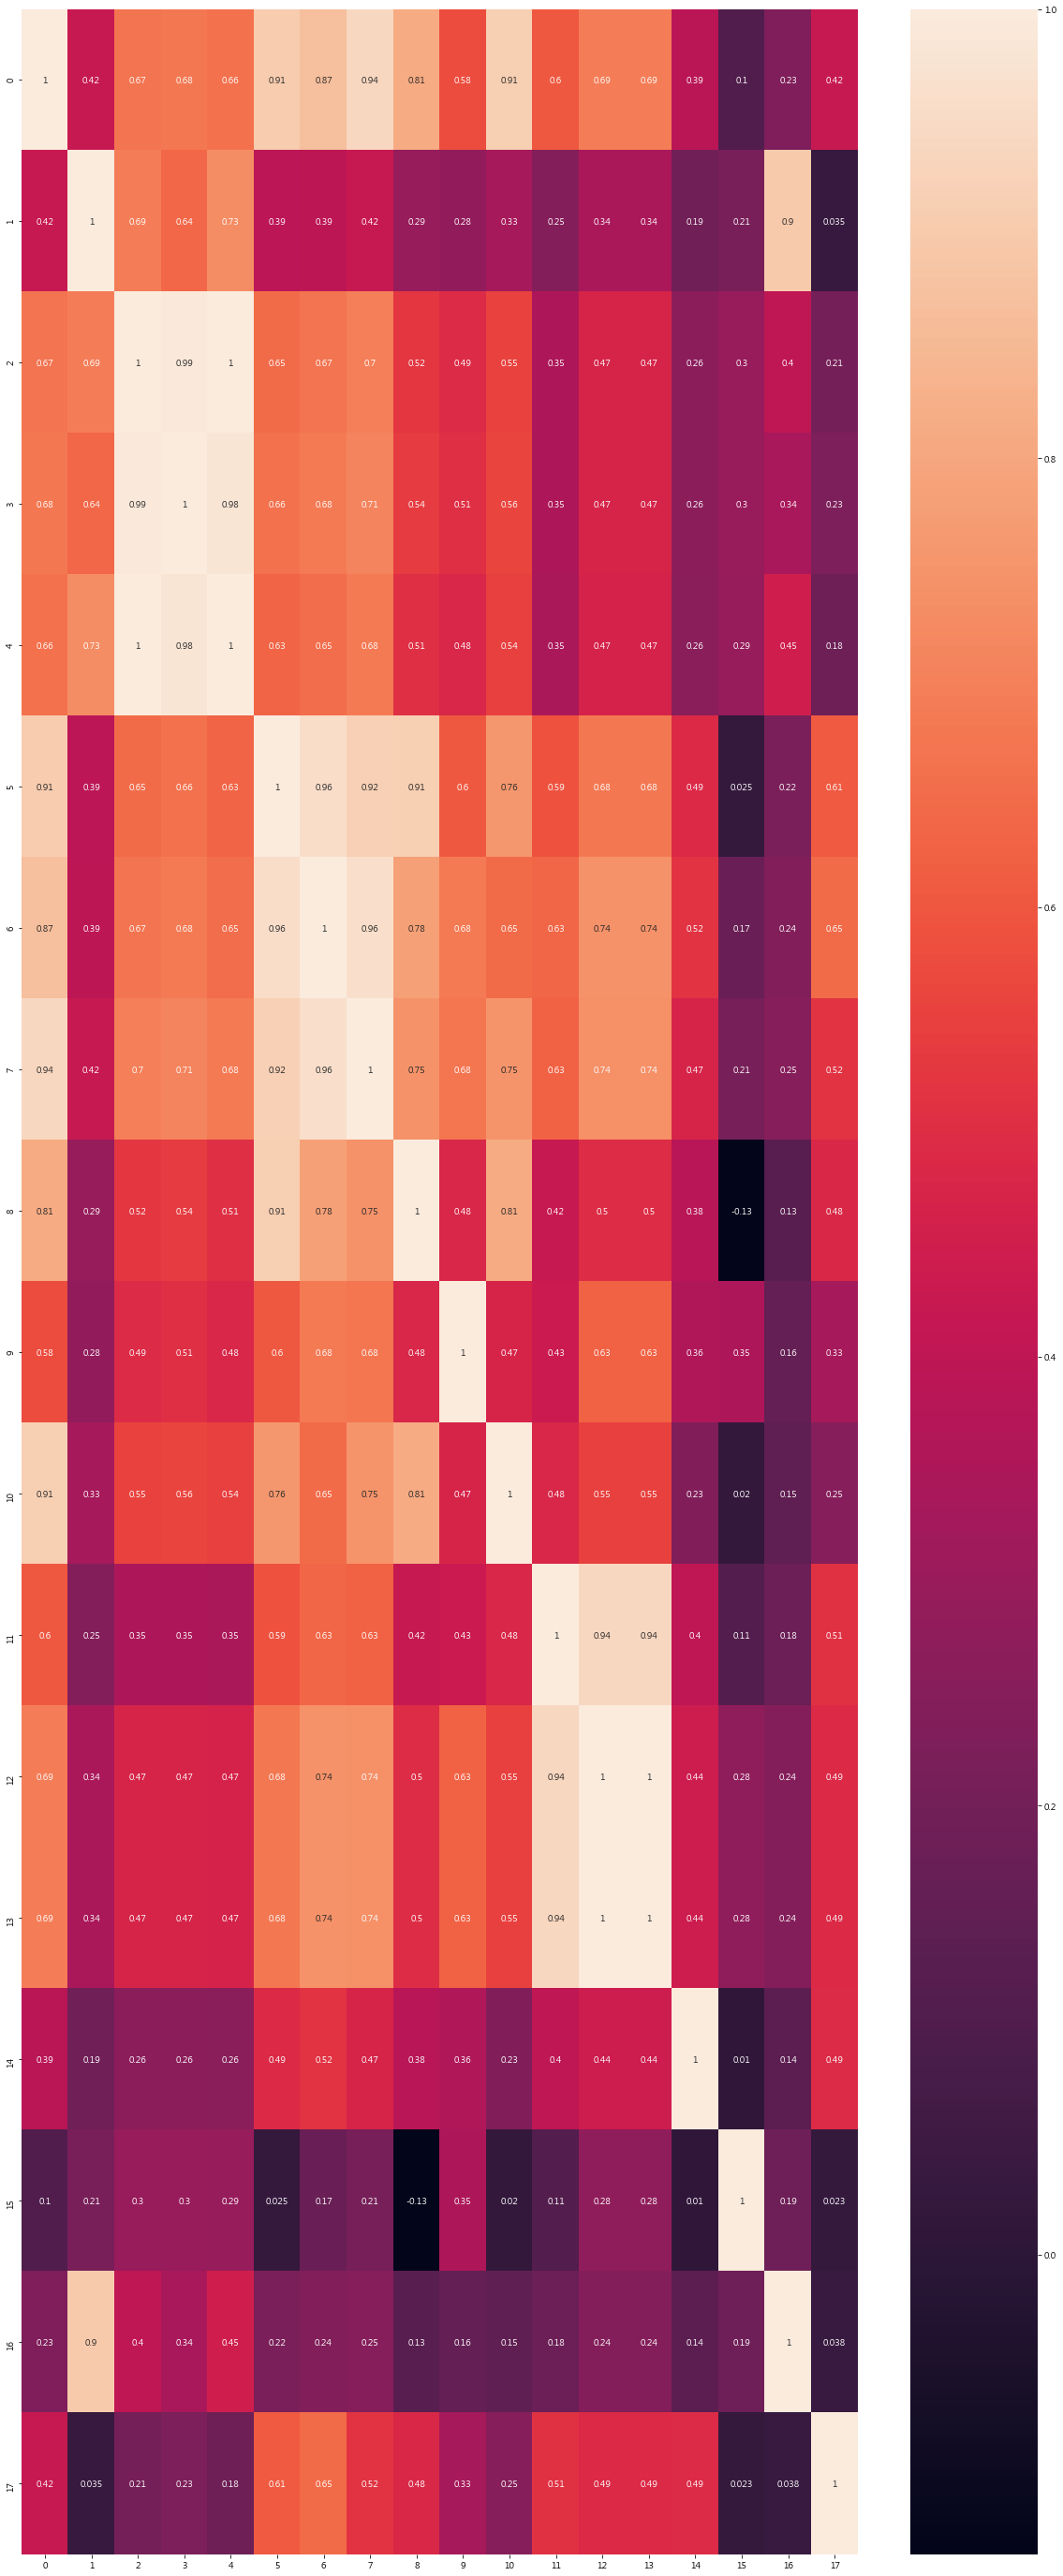

In [23]:
plt.figure(figsize=(20,50))

sns.heatmap(data = scale_Medicine.corr(), annot = True)
# plt.savefig('tmp.png')

In [24]:
# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()


x_data = scale_Medicine.iloc[:,:-1]
y_data = deep_Medicine.iloc[:,[-1]]


# parameters
placeholder_num = len(x_data.columns)
learning_rate = 0.001




X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([32]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([64]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([64]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


W4 = tf.get_variable("W4", shape=[64, 32], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([32]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


W5 = tf.get_variable("W5", shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([1]))
L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

# hypothesis = tf.matmul(L4, W5) + b5

# define cost/loss & optimizer

# Hypothesis using sigmoid: tf.div(1., 1. + tf.exp(tf.matmul(X, W)))
hypothesis = tf.sigmoid(tf.matmul(L4,W5) + b5)

# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

In [25]:
# Launch graph

validation_number = 20
#init_state = lstm_cell.zero_state(128, tf.float32)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(5001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data.iloc[:-validation_number,:], Y: y_data.iloc[:-validation_number,:], keep_prob: 0.8})       
        if step % 200 == 0 or step < 10 :
            print("Step : {} \t Cost : {}".format(step, cost_val))    

    # Accuracy report
    h1, c1, a1 = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})

Step : 0 	 Cost : 1.0138832330703735
Step : 1 	 Cost : 0.8968780636787415
Step : 2 	 Cost : 1.0009819269180298
Step : 3 	 Cost : 1.0443185567855835
Step : 4 	 Cost : 1.0072745084762573
Step : 5 	 Cost : 0.969185471534729
Step : 6 	 Cost : 0.8426543474197388
Step : 7 	 Cost : 0.9532999992370605
Step : 8 	 Cost : 0.9684571623802185
Step : 9 	 Cost : 0.8627750277519226
Step : 200 	 Cost : 0.7671461701393127
Step : 400 	 Cost : 0.7089190483093262
Step : 600 	 Cost : 0.7764403820037842
Step : 800 	 Cost : 0.739117443561554
Step : 1000 	 Cost : 0.7327023148536682
Step : 1200 	 Cost : 0.6570072770118713
Step : 1400 	 Cost : 0.7531204223632812
Step : 1600 	 Cost : 0.7295523285865784
Step : 1800 	 Cost : 0.7057479023933411
Step : 2000 	 Cost : 0.7160254120826721
Step : 2200 	 Cost : 0.662102222442627
Step : 2400 	 Cost : 0.7060034275054932
Step : 2600 	 Cost : 0.7061870098114014
Step : 2800 	 Cost : 0.7220158576965332
Step : 3000 	 Cost : 0.7103975415229797
Step : 3200 	 Cost : 0.69556593894958

In [26]:
print('모델 정확도: ', a1 * 100 , '%')

모델 정확도:  44.999998807907104 %


In [27]:
# pd.DataFrame(y_data.iloc[-validation_number:,:].values, c.ravel()).reset_index()
pd.DataFrame({'real':list(y_data.iloc[-validation_number:,:].values.ravel()),'predict': list(c1.ravel())})

,real,predict
0,0.0,1.0
1,1.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,0.0,1.0
8,1.0,1.0
9,0.0,1.0


In [28]:
h1

array([[0.61237437],
       [0.61463875],
       [0.60735095],
       [0.60992247],
       [0.61079216],
       [0.6119447 ],
       [0.5828158 ],
       [0.5829304 ],
       [0.59035444],
       [0.56495816],
       [0.58455116],
       [0.571088  ],
       [0.57889897],
       [0.59295046],
       [0.6060087 ],
       [0.6038371 ],
       [0.600329  ],
       [0.63089365],
       [0.6225512 ],
       [0.6282321 ]], dtype=float32)